In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as d

### Load and Prepare Data

In [2]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


In [3]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min_date} HeartR end: {HeartR_max_date}')
print(f'SleepL start: {SleepL_min_date} SLeepL end: {SleepL_max_date}')

ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [4]:
ACC_new = ACC[(ACC['timedelta'] > SleepL_min_date) & (ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min_date) & HeartR['timedelta']< SleepL_max_date]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min_date) & SleepL['timedelta']< SleepL_max_date]
ACC_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


### Load and Prepare Data (ACC)

In [5]:
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

C:\Users\Nuchtu\AppData\Local\Temp\ipykernel_7424\2552671504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [6]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

In [7]:
# acc_X, acc_Y, acc_Z
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy()
ACC


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


### Load and Prepare Data (Heart rate)

In [8]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))
HeartR_new

,timedelta,heartrate
0,-7 days +13:26:30,57
1,-7 days +13:26:32,56
2,-7 days +13:26:37,56
3,-7 days +13:26:41,57
4,-7 days +13:26:51,59
...,...,...
4873,0 days 04:42:39,72
4874,0 days 04:42:44,74
4875,0 days 04:42:50,75
4876,0 days 04:42:55,76


In [9]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
-7 days +13:26:30,57.0
-7 days +13:26:31,57.0
-7 days +13:26:32,56.0
-7 days +13:26:33,56.0
-7 days +13:26:34,56.0
...,...
0 days 04:42:56,76.0
0 days 04:42:57,76.0
0 days 04:42:58,76.0


### Load and Prepare Data (Sleep Label)

In [10]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],
unit='s').round('1s'))

In [11]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()

### Merge Data and Standardized data

In [12]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df,SleepL_new2, on = 'timedelta')

In [13]:
# Fill NA
# Heart rate
med_h = df.heartrate.median()
df.heartrate.fillna(med_h,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,-1.0
1,-0.240757,0.873826,0.415446,87.0,-1.0
2,-0.244620,0.883943,0.387026,87.0,-1.0
3,-0.248036,0.902427,0.347812,87.0,-1.0
4,-0.241778,0.912946,0.321502,87.0,-1.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [14]:
# Standardized data
standard = StandardScaler()
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df[feature_columns] = standard.fit_transform(df[feature_columns])
df_feature = df[feature_columns] 
df_label = df[label_columns]

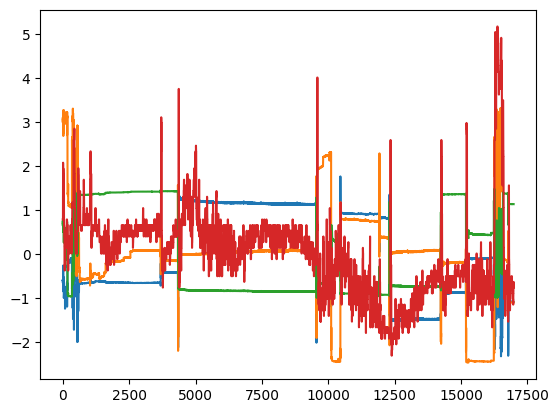

In [15]:
plt.plot([int(i) for i in range(len(df[feature_columns]))],df_feature)

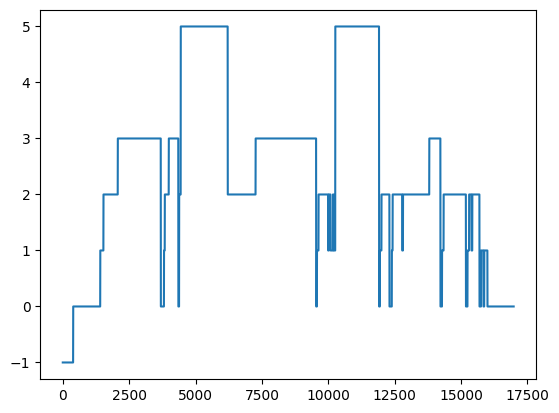

In [16]:
plt.plot([int(i) for i in range(len(df.heartrate))],df_label.sleep)

### SVM Model Training and Testing

In [17]:
from sklearn import model_selection
x = df_feature
y = df_label
seed = 30
x_train,x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=seed)

In [18]:
c_val = 100  
gmm =0.1
d = 2

In [19]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [20]:
# Model Training
svc_rbf_pred = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)

c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Model Testing (Predict)
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

### SVM Prediction Report

In [22]:
print('----- Confusion matrix of SVC Rbf -----')
print(confusion_matrix(y_test,svc_rbf_pred))
print('----- Confusion matrix of SVC Poly -----')
print(confusion_matrix(y_test,svc_poly_pred))

----- Confusion matrix of SVC Rbf -----
[[ 118    1    0    0    0    0]
 [   3  549    5  162   12    7]
 [   0   64   57  125    1   12]
 [   0   30   10 1329  104   31]
 [   0    0    0   60 1384    1]
 [   4    0    0  190    0  836]]
----- Confusion matrix of SVC Poly -----
[[ 114    5    0    0    0    0]
 [   8  528  119   64   12    7]
 [   1   13  116  108    7   14]
 [   3   27   93 1136  195   50]
 [   0   18    0  166 1261    0]
 [   0    0    1  159    9  861]]


In [23]:
print('----- Classification matrix of SVC Rbf -----')
print(classification_report(y_test,svc_rbf_pred))
print('----- Classification matrix of SVC Poly -----')
print(classification_report(y_test,svc_poly_pred))

----- Classification matrix of SVC Rbf -----
              precision    recall  f1-score   support

        -1.0       0.94      0.99      0.97       119
         0.0       0.85      0.74      0.79       738
         1.0       0.79      0.22      0.34       259
         2.0       0.71      0.88      0.79      1504
         3.0       0.92      0.96      0.94      1445
         5.0       0.94      0.81      0.87      1030

    accuracy                           0.84      5095
   macro avg       0.86      0.77      0.78      5095
weighted avg       0.85      0.84      0.83      5095

----- Classification matrix of SVC Poly -----
              precision    recall  f1-score   support

        -1.0       0.90      0.96      0.93       119
         0.0       0.89      0.72      0.79       738
         1.0       0.35      0.45      0.39       259
         2.0       0.70      0.76      0.72      1504
         3.0       0.85      0.87      0.86      1445
         5.0       0.92      0.84      0.

In [24]:
#Create Model Parameter Dictionary for SVC
k = ['rbf','poly']
C_list = [0.1, 1.0, 10.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2]
param = dict(kernel = k,C = C_list,gamma = Gamma_list,degree = d_list)

In [25]:
grid = GridSearchCV( estimator = SVC(), n_jobs = 10, verbose = 10, scoring = 'accuracy', cv = 2, param_grid = param)
grid_result = grid.fit(x_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
# Show Best Parameters 
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 10.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
Best score:  0.8980312973245835


In [27]:
means   = grid_result.cv_results_['mean_test_score']
stds    = grid_result.cv_results_['std_test_score']
params  = grid_result.cv_results_['params']
data_poly = []
data_rbf = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    if param['kernel'] == 'rbf':
        data_rbf.append({'means': mean, 'stds': stdev})
    elif param['kernel'] == 'poly':
        data_poly.append({'means': mean, 'stds': stdev})

0.504375 (0.003786) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.302541 (0.000000) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.639239 (0.014976) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.488642 (0.001851) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.734225 (0.000757) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.692580 (0.001010) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.778311 (0.000589) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
0.773347 (0.006731) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}
0.557799 (0.005216) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.322060 (0.000168) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.725139 (0.003618) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.651355 (0.002019) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.792697 (0.005553) 

<AxesSubplot:>

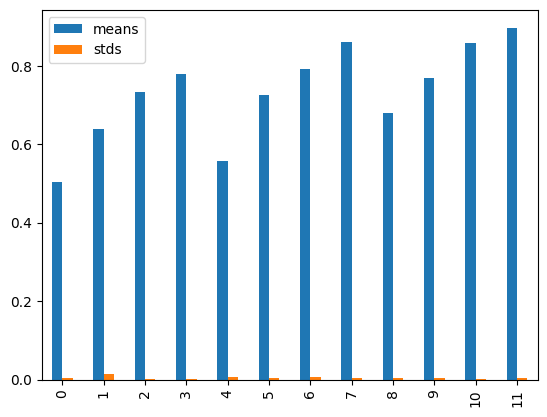

In [28]:
df_rbf = pd.DataFrame(data=data_rbf)
df_rbf.plot.bar()

<AxesSubplot:>

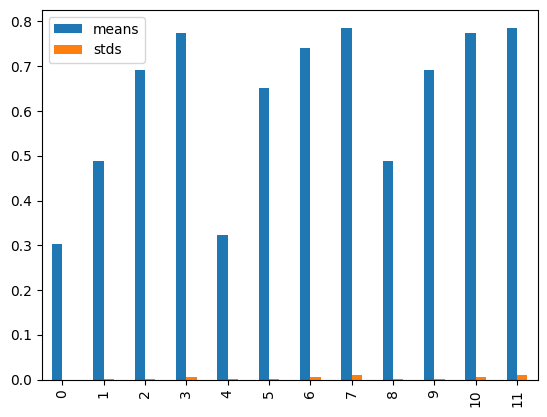

In [29]:
df_poly = pd.DataFrame(data=data_poly)
df_poly.plot.bar()